# Explicit Chang Cooper Scheme

## Imports

In [120]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import time
import numpy as np
from numba import njit, prange

# from config import sigma, beta, lamda, alpha, v0, vg, psi, D0

## Model Parameters

In [121]:
sigma = 0.001
beta = 100
lamda = 0.6
alpha = 0.1
v0 = 0.01
vg = 0
psi = np.inf
D0 = 0.00001

In [122]:

def mu_x_vec(X, Z, PHI, t):
    return (alpha*np.exp(Z)*np.cos(X)
            + v0*np.sin(PHI)
            + sigma*(beta+Z))-1


def mu_z_vec(X, Z, PHI, t):
    return alpha*np.exp(Z)*np.sin(X) + v0*np.cos(PHI) 


def mu_phi_vec(X, Z, PHI, t):
    return (lamda*alpha*np.exp(Z)*np.cos(X+2*PHI)
            + sigma/2*(1+lamda*np.cos(2*PHI)))


def diffusion_vec(X, Z, PHI, t):
    return D0 * np.ones_like(PHI)


# ----------------- CFL max speeds -----------------

def mu_x_max(X, Z, PHI, t):
    return alpha*np.exp(Z) + v0 + sigma*(beta+Z)-1


def mu_z_max(X, Z, PHI, t):
    return alpha*np.exp(Z) + v0 - vg


def mu_phi_max(X, Z, PHI, t):
    return (lamda*alpha*np.exp(Z) - 1/(2*psi) + sigma/2*(1+lamda))

def fp_compute_drifts(X, Z, PHI, t):
    """
    Compute drift and diffusion fields on the full 3D grid.

    Evaluates the drift components μ_x, μ_z, μ_φ and the diffusion
    coefficient D at each grid point.

    Parameters
    ----------
    X, Z, PHI : ndarray, shape (Nx, Nz, Nphi)
        Spatial grids in x, z, and φ.
    t : float
        Current time.

    Returns
    -------
    MU_X, MU_Z, MU_PHI, D : ndarray
        Drift components in x, z, φ directions and diffusion field,
        all with shape (Nx, Nz, Nphi).
    """
    MU_X = mu_x_vec(X, Z, PHI, t)
    MU_Z = mu_z_vec(X, Z, PHI, t)
    MU_PHI = mu_phi_vec(X, Z, PHI, t)
    D = diffusion_vec(X, Z, PHI, t)
    return MU_X, MU_Z, MU_PHI, D




## Chang-Cooper Helpers Vectors

In [123]:
def delta_cc_vec(Pe):
    """Vectorized Chang-Cooper delta function"""
    delta = np.zeros_like(Pe)
    
    # Small Pe: use limiting value
    small = np.abs(Pe) < 1e-10
    delta[small] = 0.5
    
    # Normal Pe
    large = ~small
    delta[large] = 1.0/Pe[large] - 1.0/(np.exp(Pe[large]) - 1.0)
    
    return delta

def max_velocities(x_grid, z_grid, phi_grid, t=0):
    """Compute maximum absolute drift velocities in each direction"""
    x_max = np.abs(mu_x_max(x_grid, z_grid, phi_grid, t)).max()
    z_max = np.abs(mu_z_max(x_grid, z_grid, phi_grid, t)).max()
    phi_max = np.abs(mu_phi_max(x_grid, z_grid, phi_grid, t)).max()

    return x_max, z_max, phi_max


## Using Numba to accelerate the Code

### Numba Math Engine

In [124]:
# --- Constants for BC Mapping ---
# Numba works fastest with integers, so we map strings to these:
BC_OPEN = 0
BC_NOFLUX = 1
BC_PERIODIC = 2

@njit(fastmath=True)
def _delta_cc_scalar(Pe):
    """
    Scalar implementation of the Chang-Cooper weighting.
    delta(Pe) = 1/Pe - 1/(exp(Pe) - 1)
    """
    # 1. Handle small Pe (Taylor expansion limit) to avoid 0/0
    if abs(Pe) < 1e-4:
        return 0.5 - Pe / 12.0
        
    # 2. Handle large positive Pe (avoid overflow in exp)
    # If Pe is huge, exp(Pe) is huge, 1/(exp-1) -> 0.
    # Result -> 1/Pe
    if Pe > 100.0:
        return 1.0 / Pe
        
    # 3. Handle large negative Pe
    # If Pe is negative huge, exp(Pe) -> 0. 
    # 1/(0 - 1) = -1. 
    # Result -> 1/Pe - (-1) = 1 + 1/Pe
    if Pe < -100.0:
        return 1.0 / Pe + 1.0
        
    # 4. Standard Case
    return 1.0 / Pe - 1.0 / (np.exp(Pe) - 1.0)

@njit(parallel=True, fastmath=True)
def fp_step_kernel_numba(f, MU_X, MU_Z, MU_PHI, D, 
                         dx, dz, dphi, dt, 
                         bc_x_int, bc_z_int):
    
    Nx, Nz, Nphi = f.shape
    f_new = np.zeros_like(f)
    
    # Pre-calculate inverse steps for speed
    idx = 1.0 / dx
    idz = 1.0 / dz
    idphi = 1.0 / dphi
    
    # Parallelize over the outer dimension
    for i in prange(Nx):
        for j in range(Nz):
            
            # ---------------------------------------------------------
            # PHASE 1: Pre-calculate PHI Fluxes (Periodic)
            # ---------------------------------------------------------
            # We calculate J at face k+1/2 for the entire ring at once.
            # This avoids re-calculating the expensive delta() twice per face.
            J_phi_faces = np.empty(Nphi, dtype=np.float64)
            
            for k in range(Nphi):
                k_next = 0 if k == Nphi - 1 else k + 1
                
                # Parameters at face k+1/2
                mu_face = 0.5 * (MU_PHI[i, j, k] + MU_PHI[i, j, k_next])
                D_face  = 0.5 * (D[i, j, k]      + D[i, j, k_next])
                
                # Peclet Number
                Pe = mu_face * dphi / (D_face + 1e-16)
                
                # Chang-Cooper Weighting
                delta = _delta_cc_scalar(Pe)
                
                # Flux Formulation:
                # Advection part uses the weighting to interpolate f_face
                # Diffusion part is standard centered difference
                term_adv  = mu_face * ((1.0 - delta) * f[i, j, k] + delta * f[i, j, k_next])
                term_diff = D_face  * (f[i, j, k_next] - f[i, j, k]) * idphi
                
                J_phi_faces[k] = term_adv - term_diff

            # ---------------------------------------------------------
            # PHASE 2: Main Update Loop (X, Z, and applying Phi)
            # ---------------------------------------------------------
            for k in range(Nphi):
                
                # === 1. FLUX IN X (i) ===
                
                # Right Face (i + 1/2)
                if i == Nx - 1:
                    if bc_x_int == BC_PERIODIC:
                        # Wrap around to i=0
                        i_next = 0
                        mu_face = 0.5 * (MU_X[i, j, k] + MU_X[i_next, j, k])
                        val_up = f[i, j, k] if mu_face >= 0 else f[i_next, j, k]
                        F_x_right = mu_face * val_up
                    elif bc_x_int == BC_OPEN:
                        m = MU_X[i, j, k]
                        F_x_right = m * f[i, j, k] if m > 0 else 0.0
                    else: # NOFLUX
                        F_x_right = 0.0
                else:
                    m = 0.5 * (MU_X[i, j, k] + MU_X[i+1, j, k])
                    val = f[i, j, k] if m >= 0 else f[i+1, j, k]
                    F_x_right = m * val

                # Left Face (i - 1/2)
                if i == 0:
                    if bc_x_int == BC_PERIODIC:
                        # Wrap around from i=Nx-1
                        i_prev = Nx - 1
                        mu_face = 0.5 * (MU_X[i_prev, j, k] + MU_X[i, j, k])
                        val_up = f[i_prev, j, k] if mu_face >= 0 else f[i, j, k]
                        F_x_left = mu_face * val_up
                    elif bc_x_int == BC_OPEN:
                        m = MU_X[i, j, k]
                        F_x_left = m * f[i, j, k] if m < 0 else 0.0
                    else: # NOFLUX
                        F_x_left = 0.0
                else:
                    m = 0.5 * (MU_X[i-1, j, k] + MU_X[i, j, k])
                    val = f[i-1, j, k] if m >= 0 else f[i, j, k]
                    F_x_left = m * val
                
                div_x = -(F_x_right - F_x_left) * idx

                # === 2. FLUX IN Z (j) ===
                
                # Top Face (j + 1/2)
                if j == Nz - 1:
                    if bc_z_int == BC_OPEN:
                        m = MU_Z[i, j, k]
                        F_z_top = m * f[i, j, k] if m > 0 else 0.0
                    else: 
                        F_z_top = 0.0
                else:
                    m = 0.5 * (MU_Z[i, j, k] + MU_Z[i, j+1, k])
                    val = f[i, j, k] if m >= 0 else f[i, j+1, k]
                    F_z_top = m * val

                # Bottom Face (j - 1/2)
                if j == 0:
                    if bc_z_int == BC_OPEN:
                        m = MU_Z[i, j, k]
                        F_z_bottom = m * f[i, j, k] if m < 0 else 0.0
                    else: 
                        F_z_bottom = 0.0
                else:
                    m = 0.5 * (MU_Z[i, j-1, k] + MU_Z[i, j, k])
                    val = f[i, j-1, k] if m >= 0 else f[i, j, k]
                    F_z_bottom = m * val
                
                div_z = -(F_z_top - F_z_bottom) * idz

                # === 3. FLUX IN PHI (k) ===
                
                # J_right is J_phi_faces[k]
                # J_left  is J_phi_faces[k-1] (cyclical)
                k_prev = Nphi - 1 if k == 0 else k - 1
                div_phi = -(J_phi_faces[k] - J_phi_faces[k_prev]) * idphi

                # === 4. UPDATE ===
                val_new = f[i, j, k] + dt * (div_x + div_z + div_phi)
                
                # Enforce positivity
                f_new[i, j, k] = max(0.0, val_new)

    return f_new


## Time Evolution Numba

In [125]:
def solve_fokker_planck_numba(f0, t_array, x_grid, z_grid, phi_grid,
                              bc_x='open', bc_z='open', bc_phi='periodic',
                              verbose=True, live_plot=False, plot_interval=50, 
                              save_interval=1, lower_mass_threshold=0.001,
                              time_dependent=True): # <--- NEW OPTIMIZATION FLAG
    
    # 1. Map Keywords to Integers
    bc_map = {'open': 0, 'noflux': 1, 'periodic': 2}
    bc_x_int = bc_map[bc_x]
    bc_z_int = bc_map[bc_z]
    
    # 2. Setup Grids
    Nt = len(t_array)
    Nx, Nz, Nphi = f0.shape
    dx = x_grid[1] - x_grid[0]
    dz = z_grid[1] - z_grid[0]
    dphi = phi_grid[1] - phi_grid[0]
    
    # Create Meshgrids (Memory intensive, but convenient)
    X, Z, PHI = np.meshgrid(x_grid, z_grid, phi_grid, indexing='ij')
    
    # 3. Memory Allocation
    n_saved_frames = (Nt - 1) // save_interval + 1
    
    # Check estimated memory usage for solution array
    est_mem_mb = (n_saved_frames * Nx * Nz * Nphi * 4) / (1024**2)
    if verbose:
        print(f"Allocating solution array: {est_mem_mb:.1f} MB")
        
    solution = np.zeros((n_saved_frames, Nx, Nz, Nphi), dtype=np.float32)
    t_saved = np.zeros(n_saved_frames)
    
    # Initial Condition
    solution[0] = f0
    t_saved[0] = t_array[0]
    save_idx = 1
    f = f0.copy()
    
    # 4. OPTIMIZATION: Pre-calculate Drifts if static
    if not time_dependent:
        if verbose: print("Time-independent physics detected. Pre-calculating drifts...")
        # Compute once at t=0
        MU_X, MU_Z, MU_PHI, D = fp_compute_drifts(X, Z, PHI, t_array[0])
    else:
        # Define placeholders to avoid UnboundLocalError
        MU_X, MU_Z, MU_PHI, D = None, None, None, None

    # 5. Live Plotting Setup
    if live_plot:
        plt.ion()
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        fig.suptitle(f'Live FP Evolution', fontsize=14)
    
    if verbose:
        print(f"Starting Solver. BCs: X='{bc_x}', Z='{bc_z}'. Steps: {Nt}")
    
    # =========================================================
    # TIME LOOP
    # =========================================================
    for n in range(Nt - 1):
        dt = t_array[n+1] - t_array[n]
        t = t_array[n]
        
        # A. Update Physics (Only if time-dependent)
        if time_dependent:
            MU_X, MU_Z, MU_PHI, D = fp_compute_drifts(X, Z, PHI, t)
        
        # B. Run Kernel
        # Note: We pass the pre-calculated or newly calculated arrays
        f = fp_step_kernel_numba(f, MU_X, MU_Z, MU_PHI, D, 
                                 dx, dz, dphi, dt, 
                                 bc_x_int, bc_z_int)
        
        # C. Save Data
        if (n + 1) % save_interval == 0:
            solution[save_idx] = f
            t_saved[save_idx] = t_array[n+1]
            save_idx += 1
        
        # D. Safety Checks & Monitoring (Every 100 steps)
        if (n+1) % 100 == 0 or n == 0:
            # Quick check for NaNs (Fastest check first)
            if np.isnan(f[0,0,0]) or np.any(np.isnan(f)):
                print(f"❌ NaN detected at step {n+1}!")
                return solution[:save_idx], t_saved[:save_idx]

            # Physics checks
            total_prob = np.sum(f) * dx * dz * dphi
            
            if verbose:
                print(f"Step {n+1}/{Nt-1}, t={t:.4f}, ∫f={total_prob:.6f}")

            # Mass Explosion
            if total_prob > 1.1: 
                print(f"❌ Instability detected (∫f={total_prob:.4f} > 1.1). DT likely too high.")
                return solution[:save_idx], t_saved[:save_idx]
            
            # Mass Depletion (Stop early if empty)
            if total_prob < lower_mass_threshold:
                print(f"⚠️ Simulation Empty (∫f < {lower_mass_threshold}). Stopping early.")
                return solution[:save_idx], t_saved[:save_idx]

    
    return solution, t_saved

In [126]:
def check_cfl_condition(x_grid, z_grid, phi_grid, dt, t=0, verbose=True):
    """
    Rigorous CFL stability check for 3D Advection-Diffusion.
    """
    dx = x_grid[1] - x_grid[0]
    dz = z_grid[1] - z_grid[0]
    dphi = phi_grid[1] - phi_grid[0]
    
    # 1. Get Maximum Drifts and Diffusion (Use absolute values!)
    # You need to ensure max_velocities returns the MAX ABSOLUTE velocity
    # across the whole grid.
    max_mu_x, max_mu_z, max_mu_phi = max_velocities(x_grid, z_grid, phi_grid, t)
    
    # Assuming D is constant for simplicity, otherwise take max(D)
    # Note: In your code D_r is relevant for phi. 
    # If you have D_t (translational diffusion), add it for x and z.
    D_phi = D0      # Replace with your global D_r
    D_x   = 0.0     # Replace with your global D_t
    D_z   = 0.0     # Replace with your global D_t

    # 2. Calculate Inverse Time Scales (Rates)
    # The condition is: 1/dt > sum(rates)
    
    # Advection Rates (Speed / Distance)
    rate_adv_x   = abs(max_mu_x) / dx
    rate_adv_z   = abs(max_mu_z) / dz
    rate_adv_phi = abs(max_mu_phi) / dphi  # <--- THIS WAS MISSING
    
    # Diffusion Rates (2 * D / Distance^2)
    rate_diff_x   = (2 * D_x) / (dx**2)
    rate_diff_z   = (2 * D_z) / (dz**2)
    rate_diff_phi = (2 * D_phi) / (dphi**2)
    
    # 3. Sum the rates (Conservative approach)
    # A single cell pushes mass out in all directions at once.
    total_rate = (rate_adv_x + rate_diff_x + 
                  rate_adv_z + rate_diff_z + 
                  rate_adv_phi + rate_diff_phi)
    
    if total_rate == 0:
        dt_max = np.inf
    else:
        dt_max = 1.0 / total_rate

    # 4. Check
    is_stable = dt <= dt_max
    
    if verbose:
        print("-" * 30)
        print(f"CFL Stability Analysis (dt = {dt:.2e})")
        print("-" * 30)
        print(f"Advection Limits (dt < ...):")
        print(f"  X:   {dx/max_mu_x:.2e} (v={max_mu_x:.2e})")
        print(f"  Z:   {dz/max_mu_z:.2e} (v={max_mu_z:.2e})")
        print(f"  Phi: {dphi/max_mu_phi:.2e} (v={max_mu_phi:.2e}) <--- Check this!")
        print(f"Diffusion Limits (dt < ...):")
        print(f"  Phi: {dphi**2/(2*D_phi):.2e}")
        print("-" * 30)
        print(f"Combined Max Stable dt: {dt_max:.2e}")
        
        if not is_stable:
            print(f"❌ UNSTABLE: dt is {dt/dt_max:.1f}x larger than limit.")
            print("   Probability will leak due to negative overshoots.")
        else:
            print(f"✅ STABLE")
            
    return dt_max

## Plotting Functions

In [127]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def compute_marginals(f, grids):
    """
    Computes 2D and 1D marginals from the 3D density f(x, z, phi).
    Returns a dictionary of marginals.
    """
    x_grid, z_grid, phi_grid = grids
    dx = x_grid[1] - x_grid[0]
    dz = z_grid[1] - z_grid[0]
    dphi = phi_grid[1] - phi_grid[0]

    # Integrate to get 2D densities
    f_xz = np.sum(f, axis=2) * dphi    # Integrate over phi
    f_xphi = np.sum(f, axis=1) * dz    # Integrate over z
    f_zphi = np.sum(f, axis=0) * dx    # Integrate over x

    # Integrate again to get 1D densities
    f_x = np.sum(f_xz, axis=1) * dz
    f_z = np.sum(f_xz, axis=0) * dx
    f_phi = np.sum(f_xphi, axis=0) * dx

    return {
        'xz': f_xz, 'xphi': f_xphi, 'zphi': f_zphi,
        'x': f_x, 'z': f_z, 'phi': f_phi
    }

def plot_summary(solution_list, t_array, x_grid, z_grid, phi_grid, num_snapshots=5, save_path=None):
    """
    Plots snapshots of density evolution with consistent color scaling.
    Robust to cases where solution_list is shorter than t_array (subsampling).
    """
    grids = (x_grid, z_grid, phi_grid)
    
    # --- FIX START ---
    # 1. Base the indices on the actual data available (solution_list), not t_array
    N_data = len(solution_list)
    N_time = len(t_array)
    
    # Generate indices valid for solution_list (0 to 300 in your case)
    indices = np.linspace(0, N_data - 1, num_snapshots, dtype=int)
    # --- FIX END ---

    # 2. Pre-calculate to find global max (ensures colors are comparable)
    snapshots = [compute_marginals(solution_list[i], grids) for i in indices]
    max_xz = max(np.max(s['xz']) for s in snapshots)
    max_xphi = max(np.max(s['xphi']) for s in snapshots)
    
    fig, axes = plt.subplots(3, num_snapshots, figsize=(3.5 * num_snapshots, 10), constrained_layout=True)
    
    for i, (idx, state) in enumerate(zip(indices, snapshots)):
        # --- FIX: Calculate correct time ---
        # If arrays are different lengths, map the index proportionally
        if N_data == N_time:
            t = t_array[idx]
        else:
            # Map data index to time index
            t_idx = int(idx * (N_time - 1) / (N_data - 1))
            t = t_array[t_idx]
            
        # Row 1: f(x, z)
        ax = axes[0, i]
        im1 = ax.contourf(x_grid, z_grid, state['xz'].T, levels=20, cmap='viridis', vmin=0, vmax=max_xz)
        ax.set_title(f't = {t:.2f}')
        if i == 0: ax.set_ylabel('z (Height)')
        
        # Row 2: f(x, phi)
        ax = axes[1, i]
        im2 = ax.contourf(x_grid, phi_grid, state['xphi'].T, levels=20, cmap='plasma', vmin=0, vmax=max_xphi)
        if i == 0: ax.set_ylabel('φ (Angle)')

# ... inside the loop ...

        # Row 3: 1D Marginals
        ax = axes[2, i]
        ax.plot(x_grid, state['x'], 'b-', lw=1.5, label='x')
        ax.plot(z_grid, state['z'], 'r-', lw=1.5, label='z')
        
        # --- RESTORED: Angle (phi) plot ---
        # We use a secondary y-axis if phi has a very different scale, 
        # or just plot it normally if the probability magnitudes are similar.
        ax.plot(phi_grid, state['phi'], 'g-', lw=1.5, label='φ') 
        # ----------------------------------

        ax.grid(True, alpha=0.3)
        if i == 0: 
            ax.set_ylabel('Probability')
            ax.legend(loc='upper right', fontsize='small') # Legend added back
        ax.set_xlabel('Coordinate')
        
        ax.grid(True, alpha=0.3)
        if i == 0: ax.set_ylabel('Probability')
        ax.set_xlabel('Coordinate')

    # Add colorbars to the last column only
    fig.colorbar(im1, ax=axes[0, -1], label='Density f(x,z)')
    fig.colorbar(im2, ax=axes[1, -1], label='Density f(x,φ)')
    
    fig.suptitle(f'Fokker-Planck Evolution (Total Time: {t:.2f})', fontsize=16)
    
    if save_path:
        plt.savefig(save_path, dpi=150)
        print(f"Summary saved to {save_path}")
    
    plt.show()

    """Create comprehensive summary plots after simulation"""
    dx = x_grid[1] - x_grid[0]
    dz = z_grid[1] - z_grid[0]
    dphi = phi_grid[1] - phi_grid[0]
    
    fig = plt.figure(figsize=(16, 10))
    
    # Select key time points
    time_indices = [0, len(t_array)//4, len(t_array)//2, 3*len(t_array)//4, -1]
    
    for idx, ti in enumerate(time_indices):
        f = solution[ti]
        t = t_array[ti]
        
        # Plot marginal in (x, z)
        ax = plt.subplot(3, 5, idx+1)
        f_xz = np.sum(f, axis=2) * dphi
        im = ax.contourf(x_grid, z_grid, f_xz.T, levels=15, cmap='viridis')
        ax.set_xlabel('x')
        ax.set_ylabel('z')
        ax.set_title(f't={t:.3f}')
        plt.colorbar(im, ax=ax)
        
        # Plot marginal in (x, phi)
        ax = plt.subplot(3, 5, idx+6)
        f_xphi = np.sum(f, axis=1) * dz
        im = ax.contourf(x_grid, phi_grid, f_xphi.T, levels=15, cmap='plasma')
        ax.set_xlabel('x')
        ax.set_ylabel('φ')
        plt.colorbar(im, ax=ax)
        
        # Plot 1D marginals
        ax = plt.subplot(3, 5, idx+11)
        f_x = np.sum(f, axis=(1, 2)) * dz * dphi
        f_z = np.sum(f, axis=(0, 2)) * dx * dphi
        f_phi = np.sum(f, axis=(0, 1)) * dx * dz
        ax.plot(x_grid, f_x, 'b-', label='f(x)', alpha=0.7)
        ax.plot(z_grid, f_z, 'r-', label='f(z)', alpha=0.7)
        ax.plot(phi_grid, f_phi, 'g-', label='f(φ)', alpha=0.7)
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.set_xlabel('Coordinate')
    
    plt.suptitle('Fokker-Planck Evolution Summary', fontsize=16, y=0.995)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Summary plot saved to: {save_path}")
    
    plt.show()
    
    return fig

## Run Program

### Timearray and Grid Setup

In [130]:
# --- 1. Simulation Constants (MUST MATCH LANGEVIN EXACTLY) ---
t_final = 1000
dt = 0.01
Nt = int(t_final / dt) + 1
t_array = np.linspace(0, t_final, Nt)

# --- 2. Grid Setup ---
# X-Direction: Needs to resolve cos(x), wavelength ~6.28
# Particles travel approx v_x * t_final ≈ 0.2 * 3000 = 600. 
# We give some buffer (0 to 800).
x_min, x_max = 0, 2*np.pi
Nx = 150  # dx = 0.8, which gives ~8 points per wavelength (Safe)

# Z-Direction: -4 to 0 seems fine.
z_min, z_max = -4, 0
Nz = 250    # dz = 0.08 (Fine)

# Phi-Direction: 0 to 2pi
phi_min, phi_max = 0, 2*np.pi
Nphi = 100  # dphi = 0.12 (Fine, resolves cos(2*phi) well)

x_grid = np.linspace(x_min, x_max, Nx)
z_grid = np.linspace(z_min, z_max, Nz)
phi_grid = np.linspace(phi_min, phi_max, Nphi)

dx = x_grid[1] - x_grid[0]
dz = z_grid[1] - z_grid[0]
dphi = phi_grid[1] - phi_grid[0]

X, Z, PHI = np.meshgrid(x_grid, z_grid, phi_grid, indexing='ij')

# --- 3. Initial Condition (Gaussian) ---
# Center must match Langevin (z=-2.0, phi=-pi/2)
x0, z0, phi0 = 0.0, -2.0, -0.5*np.pi  

# Sigmas: Must be resolved by the grid (> 1.5 * dx)
sigma_x   = 0.1 # 2.0 * dx    # Adapts to your grid resolution
sigma_z   = 2.0 * dz
sigma_phi = 2.0 * dphi

arg_x   = (X - x0)**2 / (2 * sigma_x**2)
arg_z   = (Z - z0)**2 / (2 * sigma_z**2)
arg_phi = (PHI - phi0)**2 / (2 * sigma_phi**2)

f0 = np.exp(-(arg_x + arg_z + arg_phi))

# Normalize
f0 = f0 / (np.sum(f0) * dx * dz * dphi)

# --- 4. Validation ---
print("="*60)
print("FOKKER-PLANCK SETUP VALIDATION")
print("="*60)
print(f"Grid: {Nx}×{Nz}×{Nphi} ({Nx*Nz*Nphi/1e6:.1f} M cells)")
print(f"Resolutions: dx={dx:.3f} (Req < 0.8), dz={dz:.3f}, dφ={dphi:.3f}")
print(f"Initial Pos: x={x0}, z={z0}, φ={phi0/np.pi:.2f}π")
print(f"Initial Widths: σx={sigma_x:.2f}, σz={sigma_z:.3f}, σφ={sigma_phi:.3f}")
print("-" * 40)

# Check Stability
# (Assuming you have your Drift functions defined elsewhere)
# For the check, we use approximate max velocities from your Langevin constants
v_x_est = 0.1 + 0.01 + 0.1 * 100 # alpha + v0 + sigma*beta roughly... wait sigma*beta is 0.001*100=0.1
# Actually, let's use the real check if possible, or an estimate:
check_cfl_condition(x_grid, z_grid, phi_grid, dt)
print(f"Current dt: {dt}")

if dx > 1.0:
    print("\n❌ CRITICAL WARNING: dx is too large to resolve cos(x-t). Physics will fail.")
else:
    print("\n✅ Grid resolution looks sufficient for wave physics.")

FOKKER-PLANCK SETUP VALIDATION
Grid: 150×250×100 (3.8 M cells)
Resolutions: dx=0.042 (Req < 0.8), dz=0.016, dφ=0.063
Initial Pos: x=0.0, z=-2.0, φ=-0.50π
Initial Widths: σx=0.10, σz=0.032, σφ=0.127
----------------------------------------
------------------------------
CFL Stability Analysis (dt = 1.00e-02)
------------------------------
Advection Limits (dt < ...):
  X:   4.73e-02 (v=8.92e-01)
  Z:   1.46e-01 (v=1.10e-01)
  Phi: 1.04e+00 (v=6.08e-02) <--- Check this!
Diffusion Limits (dt < ...):
  Phi: 2.01e+02
------------------------------
Combined Max Stable dt: 3.45e-02
✅ STABLE
Current dt: 0.01

✅ Grid resolution looks sufficient for wave physics.


## Initial State - localized Gaussian

In [132]:
print("="*60)
print("VECTORIZED 3D FOKKER-PLANCK SOLVER")
print("="*60)
print(f"Grid: {Nx}×{Nz}×{Nphi} = {Nx*Nz*Nphi:,} cells")
print(f"Resolution: dx={dx:.3f}, dz={dz:.3f}, dφ={dphi:.3f}")
print(f"x in [{x_min}, {x_max}], z in [{z_min}, {z_max}], φ in [{phi_min}, {phi_max}]")

print(f"Initial ∫f = {np.sum(f0)*dx*dz*dphi:.6f}")
print()

print(f"Time: t ∈ [0, {t_final}], dt={dt:.4e}, Nt={Nt}")

print(f"Total Memory needed: {Nt*Nx*Nz*Nphi*4/1e9:.2f} GB (float32)")
check_cfl_condition(x_grid, z_grid, phi_grid, dt)
print()

# Solve with live plotting
start_time = time.time()

# Set live_plot=True to see real-time updates (slower)
# Set live_plot=False for faster computation, then plot after

use_live_plot = False  # Change to True for live visualization

# solution = solve_fokker_planck_vectorized(f0, t_array, x_grid, z_grid, phi_grid,
#                                             bc_x='noflux', bc_z='noflux', bc_phi='periodic',
#                                             live_plot=use_live_plot, plot_interval=100, fast = False)


solution, t_sub = solve_fokker_planck_numba(f0, t_array, x_grid, z_grid, phi_grid,
                                            bc_x='periodic', bc_z='open', bc_phi='periodic',
                                            live_plot=use_live_plot, plot_interval=1000, 
                                        save_interval=1000, lower_mass_threshold=0.01, time_dependent=False)

# f = fokker_planck_step_IMEX_CC(
#         f, X, Z, PHI, t, dt, dx, dz, dphi,
#         bc_x, bc_z, bc_phi
#     )

elapsed = time.time() - start_time

print()
print("="*60)
print(f"✓ Done! Solution shape: {solution.shape}")
print(f"Final ∫f = {np.sum(solution[-1])*dx*dz*dphi:.6f}")
print(f"Computation time: {elapsed:.2f} seconds")
print(f"   ({elapsed/Nt:.4f} sec/step, {Nx*Nz*Nphi*Nt/elapsed/1e6:.2f} Mcells/sec)")
print("="*60)

# Create summary plots
print("\nGenerating summary plots...")
# plot_summary(solution, t_array, x_grid, z_grid, phi_grid, 
#                 save_path=f'./Plots/fokker_planck_summary_{time.time()}.png')
print("Done")

VECTORIZED 3D FOKKER-PLANCK SOLVER
Grid: 150×250×100 = 3,750,000 cells
Resolution: dx=0.042, dz=0.016, dφ=0.063
x in [0, 6.283185307179586], z in [-4, 0], φ in [0, 6.283185307179586]
Initial ∫f = 1.000000

Time: t ∈ [0, 1000], dt=1.0000e-02, Nt=100001
Total Memory needed: 1500.02 GB (float32)
------------------------------
CFL Stability Analysis (dt = 1.00e-02)
------------------------------
Advection Limits (dt < ...):
  X:   4.73e-02 (v=8.92e-01)
  Z:   1.46e-01 (v=1.10e-01)
  Phi: 1.04e+00 (v=6.08e-02) <--- Check this!
Diffusion Limits (dt < ...):
  Phi: 2.01e+02
------------------------------
Combined Max Stable dt: 3.45e-02
✅ STABLE

Allocating solution array: 1444.8 MB
Time-independent physics detected. Pre-calculating drifts...
Starting Solver. BCs: X='periodic', Z='open'. Steps: 100001
Step 1/100000, t=0.0000, ∫f=1.000000
Step 100/100000, t=0.9900, ∫f=1.000000
Step 200/100000, t=1.9900, ∫f=1.000000
Step 300/100000, t=2.9900, ∫f=1.000000
Step 400/100000, t=3.9900, ∫f=1.000000
St

A D = 0.001 is worse than D = 0.01

In [133]:
solution.shape

(101, 150, 250, 100)

## Expected Path

In [134]:
import numpy as np
import matplotlib.pyplot as plt

def get_expected_path(solution, t_saved, x_grid, z_grid):
    """
    Calculates the center of mass <x>(t) and <z>(t) from the 
    Fokker-Planck probability density evolution.
    
    Parameters
    ----------
    solution : ndarray (Nt, Nx, Nz, Nphi)
        The subsampled output from the FP solver.
    t_saved : ndarray (Nt)
        The time steps corresponding to the solution frames.
    x_grid, z_grid : ndarray
        The 1D spatial grids.
        
    Returns
    -------
    mu_x : ndarray
        Expected x position over time.
    mu_z : ndarray
        Expected z position over time.
    """
    Nt = len(t_saved)
    mu_x = np.zeros(Nt)
    mu_z = np.zeros(Nt)
    
    # Pre-calculate grid shapes for broadcasting if needed, 
    # but simple summation is safer and clearer.
    
    print(f"Extracting expected paths from {Nt} frames...")
    
    for n in range(Nt):
        f_t = solution[n] # Shape: (Nx, Nz, Nphi)
        
        # 1. Marginalize to get 1D distributions
        # Sum over axes (1, 2) -> (z, phi) to get P(x)
        # We don't strictly need dx/dz/dphi here because they cancel in the average
        p_x = np.sum(f_t, axis=(1, 2)) 
        
        # Sum over axes (0, 2) -> (x, phi) to get P(z)
        p_z = np.sum(f_t, axis=(0, 2))
        
        # 2. Calculate Center of Mass (Expectation Value)
        # <x> = Sum(x_i * p_i) / Sum(p_i)
        
        total_prob = np.sum(p_x)
        
        if total_prob > 1e-9:
            mu_x[n] = np.sum(x_grid * p_x) / total_prob
            mu_z[n] = np.sum(z_grid * p_z) / total_prob
        else:
            # Handle empty/finished simulation
            mu_x[n] = mu_x[n-1] if n > 0 else x_grid[0]
            mu_z[n] = mu_z[n-1] if n > 0 else z_grid[0]
            
    return mu_x, mu_z

# --- Execution ---

# 1. Calculate Paths
# Assumes 'sol_data' and 'sol_time' exist from the previous Numba solver cell
mean_x, mean_z = get_expected_path(solution, t_sub, x_grid, z_grid)



Extracting expected paths from 101 frames...


Plot saved successfully to: ./Average Plots/comoving_plot_03.png


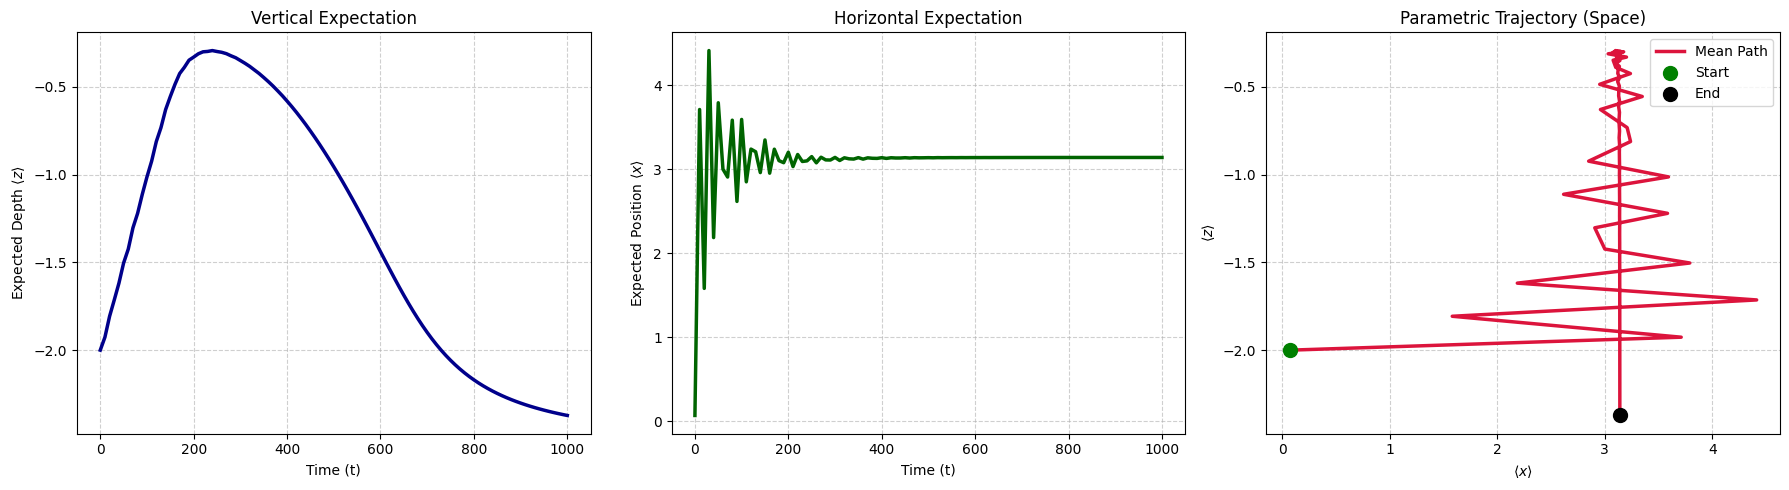

In [135]:
import os
import matplotlib.pyplot as plt

# 1. Ensure the directory exists
save_dir = "./Average Plots"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Created directory: {save_dir}")

# --- Plotting ---
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Vertical Depth vs Time
ax[0].plot(t_sub, mean_z, color='darkblue', linewidth=2.5)
ax[0].set_xlabel('Time (t)')
ax[0].set_ylabel(r'Expected Depth $\langle z \rangle$')
ax[0].set_title('Vertical Expectation')
ax[0].grid(True, linestyle='--', alpha=0.6)

# Plot 2: Horizontal Position vs Time
ax[1].plot(t_sub, mean_x, color='darkgreen', linewidth=2.5)
ax[1].set_xlabel('Time (t)')
ax[1].set_ylabel(r'Expected Position $\langle x \rangle$')
ax[1].set_title('Horizontal Expectation')
ax[1].grid(True, linestyle='--', alpha=0.6)

# Plot 3: Parametric Path (Real Space Trajectory)
ax[2].plot(mean_x, mean_z, color='crimson', linewidth=2.5, label='Mean Path')
# Mark Start and End points
ax[2].scatter([mean_x[0]], [mean_z[0]], color='green', s=100, label='Start', zorder=5)
ax[2].scatter([mean_x[-1]], [mean_z[-1]], color='black', s=100, label='End', zorder=5)

ax[2].set_xlabel(r'$\langle x \rangle$')
ax[2].set_ylabel(r'$\langle z \rangle$')
ax[2].set_title('Parametric Trajectory (Space)')
ax[2].legend()
ax[2].grid(True, linestyle='--', alpha=0.6)
ax[2].set_aspect('auto', adjustable='box') 

plt.tight_layout()

# 2. SAVE BEFORE SHOW
# Using os.path.join handles Windows/Mac path slashes correctly
save_path = os.path.join(save_dir, "comoving_plot_03.png")
plt.savefig(save_path, dpi=150, bbox_inches='tight')
print(f"Plot saved successfully to: {save_path}")

# 3. Now show it
plt.show()

In [136]:
check_cfl_condition(x_grid, z_grid, phi_grid, dt)

------------------------------
CFL Stability Analysis (dt = 1.00e-02)
------------------------------
Advection Limits (dt < ...):
  X:   4.73e-02 (v=8.92e-01)
  Z:   1.46e-01 (v=1.10e-01)
  Phi: 1.04e+00 (v=6.08e-02) <--- Check this!
Diffusion Limits (dt < ...):
  Phi: 2.01e+02
------------------------------
Combined Max Stable dt: 3.45e-02
✅ STABLE


0.03452155351037055

## Animation and Summary Plotting

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter

def save_animation(solution_list, t_array, x_grid, z_grid, phi_grid, filename='evolution.mp4', fps=30):
    print(f"Generating animation ({filename})...")
    
    # Grid setup
    grids = (x_grid, z_grid, phi_grid)
    
    # --- SETUP PLOT LAYOUT ---
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    ax_xz, ax_xphi = axes[0, 0], axes[0, 1]
    ax_zphi, ax_1d = axes[1, 0], axes[1, 1]
    
    # 1. Pre-compute first frame to set limits
    s0 = compute_marginals(solution_list[0], grids)
    
    # Scaling factors (keeps colors consistent so you can see fading)
    # We take a fraction of the max to make details visible
    vmax_xz = np.max(s0['xz']) * 0.9 
    vmax_xphi = np.max(s0['xphi']) * 0.9
    vmax_zphi = np.max(s0['zphi']) * 0.9

    # 2. Create Initial Plots (Using pcolormesh for speed)
    # Note: .T is used to align (x, z) dimensions with the axes correctly
    im_xz = ax_xz.pcolormesh(x_grid, z_grid, s0['xz'].T, cmap='viridis', shading='auto', vmin=0, vmax=vmax_xz)
    im_xphi = ax_xphi.pcolormesh(x_grid, phi_grid, s0['xphi'].T, cmap='plasma', shading='auto', vmin=0, vmax=vmax_xphi)
    im_zphi = ax_zphi.pcolormesh(z_grid, phi_grid, s0['zphi'].T, cmap='coolwarm', shading='auto', vmin=0, vmax=vmax_zphi)
    
    # 3. Create 1D Lines
    line_x, = ax_1d.plot(x_grid, s0['x'], 'b-', lw=2, label='x')
    line_z, = ax_1d.plot(z_grid, s0['z'], 'r-', lw=2, label='z')
    line_phi, = ax_1d.plot(phi_grid, s0['phi'], 'g-', lw=2, label='φ')
    
    # Decoration
    ax_xz.set_title('Density f(x,z)')
    ax_xz.set_ylabel('z')
    ax_xphi.set_title('Density f(x,φ)')
    ax_xphi.set_ylabel('φ')
    ax_zphi.set_title('Density f(z,φ)')
    ax_zphi.set_ylabel('φ')
    ax_zphi.set_xlabel('z')
    
    ax_1d.legend(loc='upper right')
    ax_1d.set_title('1D Marginals')
    ax_1d.set_ylim(0, np.max(s0['x'])*1.5) # Fix Y-axis so lines don't jump
    ax_1d.grid(True, alpha=0.3)
    
    title = fig.suptitle(f'Time: {t_array[0]:.3f}')

    # --- ANIMATION LOOP ---
    def update(frame_idx):
        # Calculate correct time index (handles mismatched array lengths)
        N_data = len(solution_list)
        N_time = len(t_array)
        t_idx = int(frame_idx * (N_time - 1) / (N_data - 1))
        
        # Get data
        s = compute_marginals(solution_list[frame_idx], grids)
        
        # Update Heatmaps (flatten data for set_array)
        im_xz.set_array(s['xz'].T.ravel())
        im_xphi.set_array(s['xphi'].T.ravel())
        im_zphi.set_array(s['zphi'].T.ravel())
        
        # Update Lines
        line_x.set_ydata(s['x'])
        line_z.set_ydata(s['z'])
        line_phi.set_ydata(s['phi'])
        
        title.set_text(f'Time: {t_array[t_idx]:.3f}')
        return im_xz, im_xphi, im_zphi, line_x, line_z, line_phi, title

    # Stride: Skip frames if you have too many (aim for ~300 frames max for speed)
    total_frames = len(solution_list)
    stride = max(1, total_frames // 300) 
    frames = range(0, total_frames, stride)
    
    anim = FuncAnimation(fig, update, frames=frames, blit=False)
    
    # --- SAVING ---
    try:
        if filename.endswith('.mp4'):
            anim.save(filename, writer=FFMpegWriter(fps=fps))
        else:
            anim.save(filename, writer=PillowWriter(fps=fps))
        print(f"Success! Animation saved to: {filename}")
    except Exception as e:
        print(f"Error saving video: {e}")
        print("Try changing filename to 'evolution.gif' to use the simpler GIF writer.")
        
    plt.close()

In [ ]:
# To save as MP4 (Best quality, requires ffmpeg installed)
# save_animation(solution, t_array, x_grid, z_grid, phi_grid, filename='evolution.mp4')

# OR

# To save as GIF (Works everywhere, no extra install needed)
# save_animation(solution, t_array, x_grid, z_grid, phi_grid, filename='evolution.gif')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

def plot_summary_log(solution_list, t_array, x_grid, z_grid, phi_grid, num_snapshots=5):
    grids = (x_grid, z_grid, phi_grid)
    
    # 1. Select Indices
    N_data = len(solution_list)
    indices = np.linspace(0, N_data - 1, num_snapshots, dtype=int)
    snapshots = [compute_marginals(solution_list[i], grids) for i in indices]
    
    # 2. Find Global Limits for Log Scale
    # We set vmin to a small number (e.g., 1e-4 * max) to avoid log(0) errors
    global_max = max(np.max(s['xz']) for s in snapshots)
    global_min = global_max * 1e-4  # Show 4 orders of magnitude
    
    fig, axes = plt.subplots(3, num_snapshots, figsize=(3.5 * num_snapshots, 10), constrained_layout=True)
    
    for i, (idx, state) in enumerate(zip(indices, snapshots)):
        # Calculate time
        t_idx = int(idx * (len(t_array) - 1) / (N_data - 1))
        t = t_array[t_idx]
        
        # Row 1: Log-Scale f(x, z)
        ax = axes[0, i]
        # Adding a tiny epsilon to data prevents log(0) warnings
        data_xz = state['xz'].T + 1e-20 
        im1 = ax.contourf(x_grid, z_grid, data_xz, levels=np.logspace(np.log10(global_min), np.log10(global_max), 20), 
                          norm=LogNorm(vmin=global_min, vmax=global_max), cmap='viridis')
        ax.set_title(f't = {t:.2f}')
        if i == 0: ax.set_ylabel('z (Height)')
        
        # Row 2: Log-Scale f(x, phi)
        ax = axes[1, i]
        data_xphi = state['xphi'].T + 1e-20
        im2 = ax.contourf(x_grid, phi_grid, data_xphi, levels=np.logspace(np.log10(global_min), np.log10(global_max), 20),
                          norm=LogNorm(vmin=global_min, vmax=global_max), cmap='plasma')
        if i == 0: ax.set_ylabel('φ (Angle)')

        # Row 3: 1D Marginals (Standard Scale)
        ax = axes[2, i]
        ax.plot(x_grid, state['x'], 'b-', label='x')
        ax.plot(z_grid, state['z'], 'r-', label='z')
        # Check if Mass is conserved
        mass = np.sum(state['x']) * (x_grid[1]-x_grid[0])
        ax.text(0.05, 0.9, f"Mass: {mass:.2f}", transform=ax.transAxes, fontsize=8, color='k')
        
        ax.grid(True, alpha=0.3)
        if i == 0: ax.legend(loc='upper right')

    # Add Colorbar (Log format)
    plt.colorbar(im1, ax=axes[0, -1], label='Log Density')
    
    plt.show()

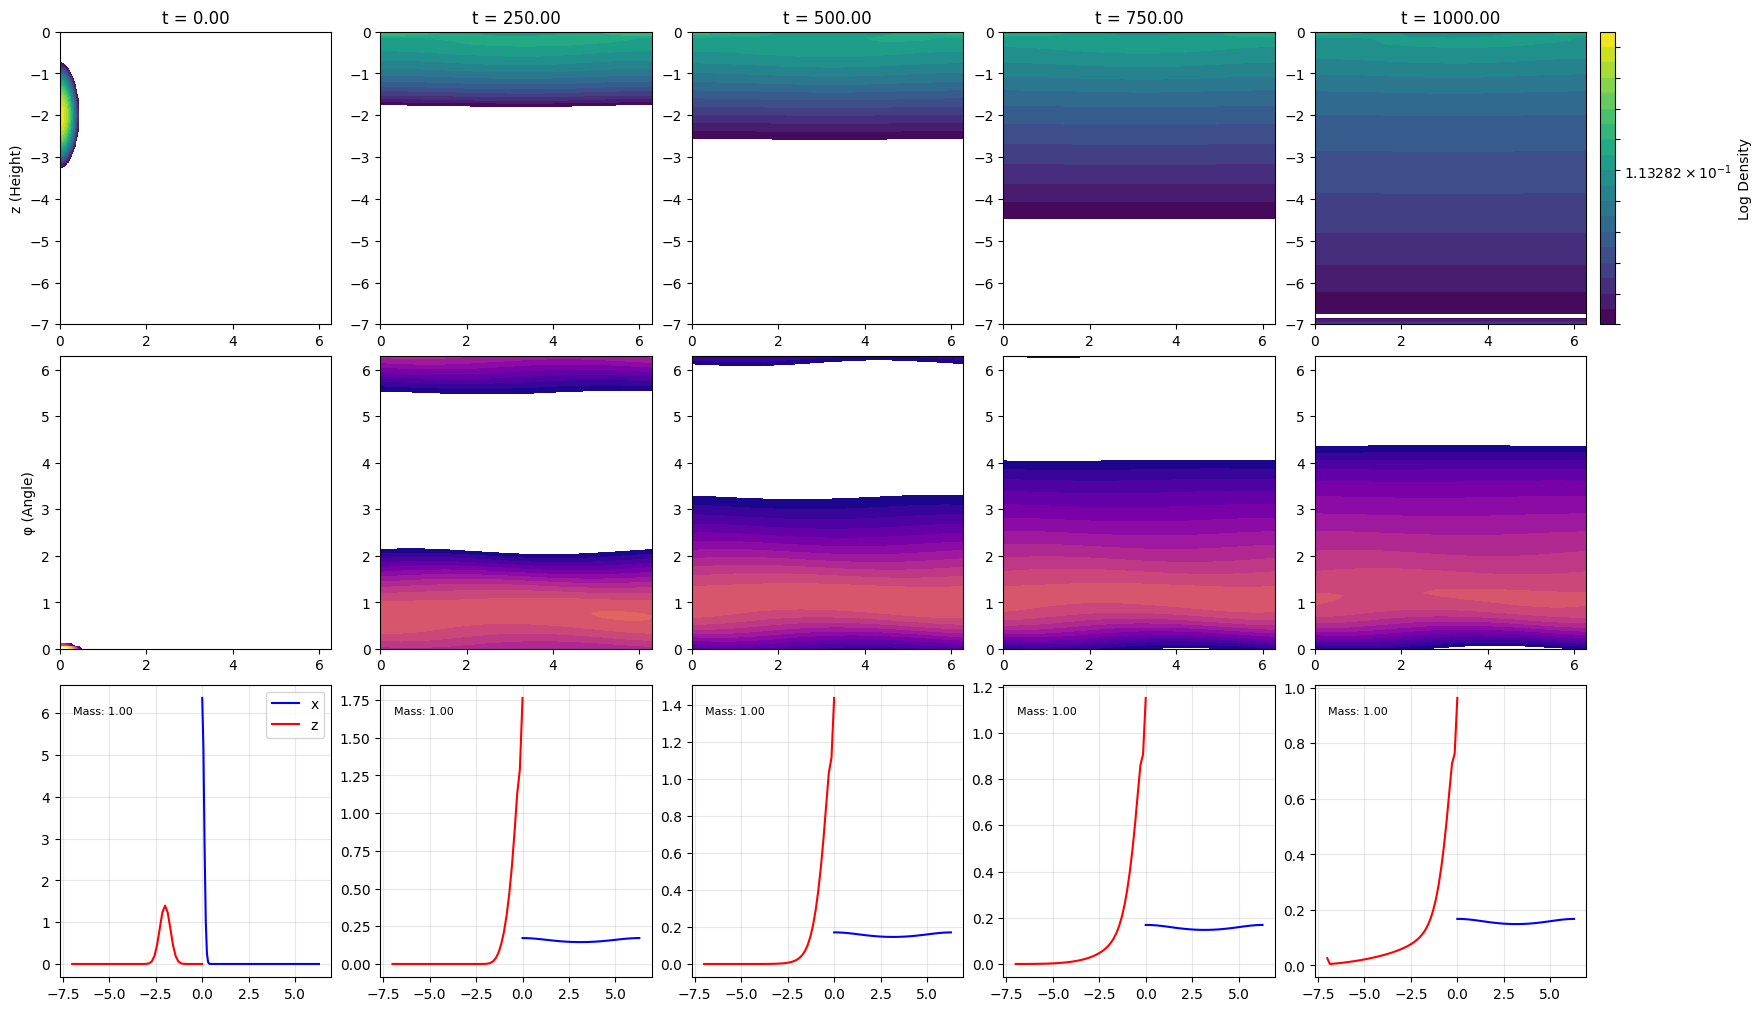

In [ ]:
plot_summary_log(solution, t_array, x_grid, z_grid, phi_grid, num_snapshots=5)

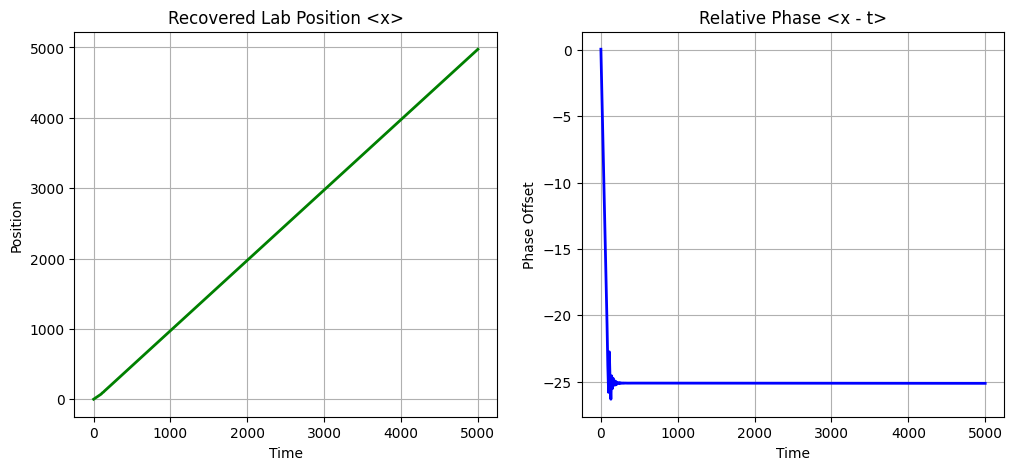

In [ ]:
def get_path_lab_frame(solution, t_saved, xi_grid, z_grid):
    """
    Transforms Co-Moving Frame (Xi, Z) -> Lab Frame (X, Z).
    Handles periodic unwrapping of Xi.
    """
    Nt = len(t_saved)
    mu_xi_wrapped = np.zeros(Nt)
    mu_z = np.zeros(Nt)
    
    # 1. Calculate Expectations in Co-Moving Frame
    for n in range(Nt):
        f_t = solution[n]
        
        # Marginalize
        p_xi = np.sum(f_t, axis=(1, 2))
        p_z  = np.sum(f_t, axis=(0, 2))
        
        # Circular Mean for Xi (since it's periodic 0..2pi)
        # This prevents the average from "jumping" when mass crosses the boundary
        sin_avg = np.sum(np.sin(xi_grid) * p_xi)
        cos_avg = np.sum(np.cos(xi_grid) * p_xi)
        mu_xi_wrapped[n] = np.arctan2(sin_avg, cos_avg)
        
        # Standard Mean for Z
        mu_z[n] = np.sum(z_grid * p_z) / np.sum(p_z)

    # 2. Unwrap the Phase
    # Turns sawtooth pattern into continuous line
    mu_xi_smooth = np.unwrap(mu_xi_wrapped)
    
    # 3. Transform to Lab Frame
    # x_lab = xi + t
    mu_x_lab = mu_xi_smooth + t_saved
    
    return mu_x_lab, mu_z

# --- Plotting ---
mean_x, mean_z = get_path_lab_frame(solution, t_sub, x_grid, z_grid)

plt.figure(figsize=(12, 5))

# Plot 1: The real trajectory (Linear)
plt.subplot(1, 2, 1)
plt.plot(t_sub, mean_x, 'g-', lw=2)
plt.title("Recovered Lab Position <x>")
plt.xlabel("Time")
plt.ylabel("Position")
plt.grid(True)

# Plot 2: The Phase/Relative Position (Oscillating/Stable)
plt.subplot(1, 2, 2)
plt.plot(t_sub, mean_x - t_sub, 'b-', lw=2) # This is <xi>
plt.title("Relative Phase <x - t>")
plt.xlabel("Time")
plt.ylabel("Phase Offset")
plt.grid(True)

plt.show()